In [1]:
####

In [2]:
import torch
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets , transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision.utils import make_grid

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def show_tensor_images(image_tensor, num_images=2, size=(1 , 28 , 28)):
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model , self).__init__()

        self.conv1 = nn.Conv2d(1 , 10 , kernel_size = 5)
        self.conv2 = nn.Conv2d(10 , 20 , kernel_size=5)
        self.dropout2d = nn.Dropout2d()

        self.fc1 = nn.Linear(320 , 50)
        self.fc2 = nn.Linear(50 , 10)
        self.relu = nn.ReLU()
        self.dropout1d = nn.Dropout()
        self.softmax = nn.Softmax()
        self.maxpool = nn.MaxPool2d(kernel_size=2 , stride=2)

    def forward(self , x):
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.dropout2d(self.maxpool(self.conv2(x))))
        x = x.view(-1 , 320)
        x = self.fc1(x)
        x = self.softmax(self.fc2(x))
        return x

In [6]:
model = Model().to(device)
x = torch.randn(2 , 1 , 28 , 28).to(device)
z = model(x)
z.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([2, 10])

In [7]:

test_dataloader = DataLoader(
    datasets.MNIST(
        '../data' , 
        train = False , 
        transform = transforms.Compose([transforms.ToTensor()]) , 
        download = True
    ) , 
    batch_size = 1 , 
    shuffle = True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


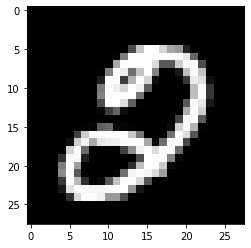

tensor([2])


In [8]:
for x , y in test_dataloader:
    show_tensor_images(x)
    print(y)
    break

In [10]:
pretrained_model = '/content/drive/MyDrive/lenet_mnist_model.pth'

In [11]:
model = Model().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location=device))

<All keys matched successfully>

In [77]:
def pgd(model , image , label , loss , eps = 0.3 , alpha = 2/255 , iters = 40):
    original_image = image.data

    for i in range(iters):
        image.requires_grad = True
        output = model(image)
        model.zero_grad()
        loss_ = loss(output , label)
        loss_.backward()

        adversarial_image = image + alpha * image.grad.sign()
        eta = torch.clamp(adversarial_image - original_image , min = -eps , max = eps)
        image = torch.clamp(original_image + eta , min = 0 , max = 1).detach_()
    return image

In [78]:
loss = nn.CrossEntropyLoss()

In [79]:
def attack(model , dataloader):
    model.eval()
    correct = 0
    total = 0

    for image , label in dataloader:
        label = label.to(device)
        image = image.to(device)
        adversarial_image = pgd(model , image , label , loss)
        output = model(adversarial_image)
        _ , output = torch.max(output.data , 1)
        total += 1
        correct +=  (output == label).sum()
        #show_tensor_images(adversarial_image)
    print(total , correct , total-correct)

In [80]:
attack(model , test_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10000 tensor(5) tensor(9995)


In [88]:
def test(model , dataloader  , device , epsilon = 0.3):
    adv_examples = []
    correct = 0

    for data , target in dataloader:
        data , target = data.to(device) , target.to(device)

        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1 , keepdim = True)[1]

        if init_pred != target:
            continue
        

       
        adversarial_image = pgd(model , data , target , loss)

        output = model(adversarial_image)
        final_output = output.max(1 , keepdim = True)[1]

        if final_output.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = adversarial_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_output.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = adversarial_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_output.item(), adv_ex) )

    final_accuracy = correct/float(len(dataloader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(dataloader), final_accuracy))
    return final_accuracy , adv_examples

In [89]:
accuracies = []
examples = []
acc, ex = test(model, test_dataloader,  device)
accuracies.append(acc)
examples.append(ex)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epsilon: 0.3	Test Accuracy = 5 / 10000 = 0.0005


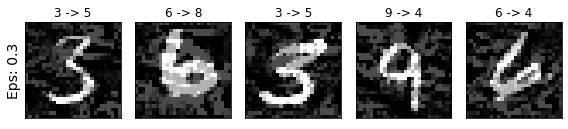

In [91]:
epsilon = [0.3]
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilon)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilon),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilon[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()